## Feature Engineering
As we observed during EDA, there is no direction relation between target variable (price_up_tomorrow) and input features. This is because, we calculated the target column using current and previous day data while input features are given for the same day so "price_up_tomorrow" is not related in any way. To overcome this, we need to perform feature engineering where we will add more columns/indicators (like momentum, volatility) and RSI (momentum indicator to measure speed and magnitude) which are commonly used by traders to fine useful pattern and discover the correlation

In [1]:
import pandas as pd

Loading the data into a data frame

In [3]:
import pandas as pd

# Load the Parquet file
pricee_s_a = pd.read_parquet('../data/processed/price_features.parquet')

# Preview the data
pricee_s_a.head()

,date,symbol,open,close,low,high,volume,close_lag1,log_return_1d,target_next_day_return,price_up_tomorrow
0,2010-01-05,A,22.324749,22.145923,22.002861,22.331903,4186000.0,22.389128,-0.010922,-0.003559,0
1,2010-01-06,A,22.067240,22.067240,22.002861,22.174536,3243700.0,22.145923,-0.003559,-0.001298,0
2,2010-01-07,A,22.017168,22.038626,21.816881,22.045780,3095100.0,22.067240,-0.001298,-0.000325,0
3,2010-01-08,A,21.917024,22.031474,21.745350,22.067240,3733900.0,22.038626,-0.000325,0.000649,1
4,2010-01-11,A,22.088697,22.045780,21.938484,22.210300,4781500.0,22.031474,0.000649,-0.012078,0


In [4]:
import pandas as pd
import numpy as np

# Ensure data is sorted
pricee_s_a = pricee_s_a.sort_values(['symbol', 'date']).reset_index(drop=True)

# --- Feature Engineering per symbol ---
engineered_dfs = []

# Define function for RSI
def compute_rsi(close, period=14):
    delta = close.diff()

    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

for symbol, group in pricee_s_a.groupby('symbol'):
    g = group.copy()

    # 1️⃣ Lagged log returns (1, 2, 3 days)
    for lag in [1, 2, 3]:
        g[f'log_return_lag{lag}'] = g['log_return_1d'].shift(lag)

    # 2️⃣ Rolling statistics (momentum features)
    g['rolling_mean_5'] = g['close'].rolling(window=5).mean()
    g['rolling_mean_10'] = g['close'].rolling(window=10).mean()
    g['rolling_std_5'] = g['close'].rolling(window=5).std()
    g['rolling_std_10'] = g['close'].rolling(window=10).std()

    # 3️⃣ Momentum: difference between recent close & moving average
    g['momentum_5'] = g['close'] / g['rolling_mean_5'] - 1
    g['momentum_10'] = g['close'] / g['rolling_mean_10'] - 1

    # 4️⃣ Volume-related features
    g['volume_change_1d'] = g['volume'].pct_change()
    g['volume_zscore_10'] = (g['volume'] - g['volume'].rolling(10).mean()) / g['volume'].rolling(10).std()

    # 5️⃣ Price ratio features
    g['high_low_ratio'] = g['high'] / g['low']
    g['close_open_ratio'] = g['close'] / g['open']

    # 6️⃣ Relative Strength Index (rsi) (14-day default)
    g['rsi_14'] = compute_rsi(g['close'], period=14)

    # Drop NaNs introduced by rolling/lags/rsi
    g = g.dropna()

    engineered_dfs.append(g)

pricee_feat = pd.concat(engineered_dfs).reset_index(drop=True)
print("Feature-engineered data shape:", pricee_feat.shape)
pricee_feat.head()


Feature-engineered data shape: (843745, 25)


,date,symbol,open,close,low,high,volume,close_lag1,log_return_1d,target_next_day_return,...,rolling_mean_10,rolling_std_5,rolling_std_10,momentum_5,momentum_10,volume_change_1d,volume_zscore_10,high_low_ratio,close_open_ratio,rsi_14
0,2010-01-25,A,21.044350,21.065809,20.908441,21.208870,3608500.0,20.865522,0.009553,-0.005448,...,21.753219,0.534536,0.444022,-0.022050,-0.031600,-0.153530,-0.719029,1.014369,1.001020,32.235311
1,2010-01-26,A,21.008583,20.951359,20.729614,21.101574,2696800.0,21.065809,-0.005448,-0.004105,...,21.643777,0.504036,0.495761,-0.017510,-0.031992,-0.252653,-1.235154,1.017943,0.997276,31.065770
2,2010-01-27,A,20.886982,20.865522,20.550787,20.951359,4362100.0,20.951359,-0.004105,-0.016592,...,21.552218,0.408227,0.549242,-0.011856,-0.031862,0.617510,0.022182,1.019492,0.998973,30.995485
3,2010-01-28,A,20.836911,20.522175,20.379112,21.008583,4937100.0,20.865522,-0.016592,-0.023273,...,21.409156,0.202926,0.615617,-0.015915,-0.041430,0.131817,0.415071,1.030888,0.984895,28.189324
4,2010-01-29,A,20.693848,20.050072,19.971388,20.865522,5923000.0,20.522175,-0.023273,0.038493,...,21.185980,0.411709,0.666528,-0.030976,-0.053616,0.199692,1.402356,1.044771,0.968890,24.863902


### Correlation Heatmap After Feature Engineering

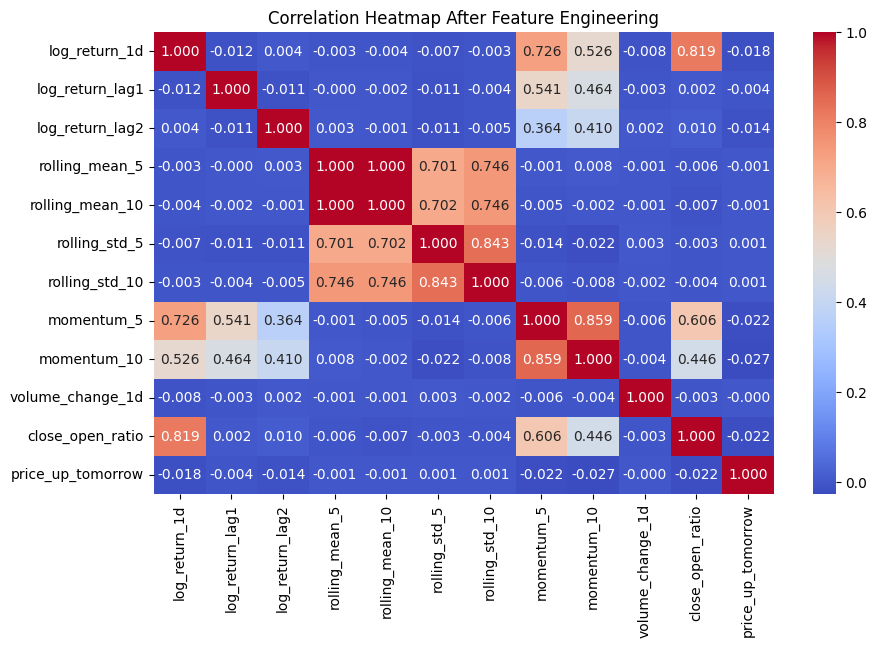

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = pricee_feat[[
    'log_return_1d', 'log_return_lag1', 'log_return_lag2', 'rolling_mean_5', 'rolling_mean_10',
    'rolling_std_5', 'rolling_std_10', 'momentum_5', 'momentum_10', 'volume_change_1d', 'close_open_ratio', 'price_up_tomorrow'
]].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Correlation Heatmap After Feature Engineering")
plt.show()


### Key observations:

No Linear Predictors: No single feature shows a strong linear correlation with the target (price_up_tomorrow), confirming the problem is non-linear.

High Feature Redundancy: Significant multicollinearity exists between key features (e.g., momentum indicators, rolling statistics).

Model Strategy Validated: This justifies using models which handle multicollinearity and uncover complex non-linear relationships effectively.


### Export processed data

In [125]:
from pathlib import Path
# Define the directory as a Path (does NOT create it yet)
processed_path = Path("../data/processed")
# Create the directory (mkdir returns None, so do NOT overwrite the variable)
processed_path.mkdir(parents=True, exist_ok=True)
# Build the full file path using /
file_path = processed_path / "price_features.parquet"
# Save parquet using the Path object
pricee_feat.to_parquet(file_path, index=False)